In [643]:
from scapy.all import *
from pprint import pprint
import sys
import numpy as np
import os
import dpkt
import socket
from collections import defaultdict


In [644]:
def read_pcap(out_dir, dst_mac_is_ts = True, try_compare_counters = True):
    
    if try_compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
                
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    
    timestamps = defaultdict(lambda : defaultdict(list))
    seqs = defaultdict(lambda : defaultdict(set))
    dups = 0
    ports = set()
    
    for i, (ts, buf) in enumerate(pcap):
        eth = dpkt.ethernet.Ethernet(buf)
        try:
            ip = dpkt.ip.IP(eth.data)
#             print(ip.len)
            src = socket.inet_ntoa(ip.src)
            dst = socket.inet_ntoa(ip.dst)
        except dpkt.UnpackError:
            continue
        tcp = ip.data
        if not isinstance(tcp, dpkt.tcp.TCP):
            continue
        if (tcp.flags & dpkt.tcp.TH_PUSH) == 0:
            continue
        
        if src == '10.0.0.101':
            ports.add(tcp.sport)
        
        x3, x2, x1 = struct.unpack("!HHH", eth.dst)
        ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
        
        seq = tcp.seq
        if seq not in seqs[src][dst]:
            seqs[src][dst].add(seq)
            timestamps[src][dst].append((ts, tcp.data))
        else:
            dups += 1

    output = dict(timestamps)
    for k in list(output.keys()):
        output[k] = dict(timestamps[k])
    print("Discarded %d dups" % dups)
    print(ports)
    return output
        

In [664]:
def to_key(buf):
    return ':'.join(buf.decode('utf-8').split()[:2]).split('\\')[0]

def to_dict(ts):
    d = defaultdict(list)
    for t, buf in ts:
        key = ':'.join(buf.decode('utf-8').split()[:2]).split('\\')[0]
        d[key].append(t)
    for k in d.keys():
        d[k] = sorted(d[k])
        
    d = dict(d)
    return d
        
def to_df(to_cache, from_cache):
    from_d = to_dict(from_cache)
    bad_keys = set()
    rows = []
    for to_ts, buf in to_cache:
        k = to_key(buf)
        if k in bad_keys:
            continue
        if k.startswith('set'):
            from_ts = from_d['STORED'].pop(0)
#             print(len(from_d['STORED']))
            rows.append([to_ts, from_ts, k, 'set'])
        elif k.startswith('get'):
            from_k = k.replace('get', 'VALUE')
            if from_k not in from_d or len(from_d[from_k]) == 0:
                print(from_k)
                print('shit')
                continue
            from_ts = from_d[from_k].pop(0)
            if (from_ts < to_ts):
                bad_keys.add(k)
                print(k)
                print('poop')
                continue
            rows.append([to_ts, from_ts, k, 'get'])
            
    df =  pd.DataFrame(rows, columns=('to', 'from', 'key', 'action'))
    for k in bad_keys:
        df = df[df.key != k]
    return df

In [688]:
def combine_dfs(cdf, sdf):
    totdf = cdf.copy()
    totdf['s_to'] = -1
    totdf['s_from'] = -1
    
    for _, (t, f, k, a) in sdf.iterrows():
        totk = totdf[totdf['key'] == k]
        totk = totk[(totk['to'] < t) & (totk['from'] > f) ]
        totk = totk[(totk['s_to'] == -1)]
        if len(totk) > 1:
            totk = totk[totk['to'] == totk['to'].min()]
        
        totdf.loc[totdf.index == totk.index[0],'s_to'] = t
        totdf.loc[totdf.index == totk.index[0],'s_from'] = f
        
    return totdf
    
def reduce_df(tot_df):
    indf = tot_df[['to', 'from', 'action']]
    indf = indf.rename(columns={'to': 'in', 'from': 'out'})
    indf.loc[tot_df['s_to'] != -1,'out'] = tot_df[tot_df['s_to'] != -1]['s_to']

    outdf = tot_df[['s_from', 'from', 'action']]
    outdf = outdf.rename(columns={'s_from': 'in', 'from': 'out'})
    outdf = outdf[outdf['in'] > 0]
    
    return indf, outdf

In [666]:
import pickle
timestamps = read_pcap('../execution/test/mcrouter_test')

Expecting 27276 packets
Reading ../execution/test/mcrouter_test/moongen/moongen.pcap
Discarded 0 dups
{11222, 53526}


In [678]:
c_to_mcr = timestamps['10.0.0.7']['10.0.0.101']
mcr_to_c = timestamps['10.0.0.101']['10.0.0.7']
mcd_to_mcr = timestamps['10.0.0.4']['10.0.0.101']
mcr_to_mcd = timestamps['10.0.0.101']['10.0.0.4']

In [679]:
f_dict = to_dict(mcr_to_mcd)
r_dict = to_dict(mcd_to_mcr)

In [680]:
c_df = to_df(c_to_mcr, mcr_to_c)
# print("SERVER")
s_df = to_df(mcr_to_mcd, mcd_to_mcr)

In [682]:
tot_df = combine_dfs(c_df, s_df)

In [689]:
indf, outdf = reduce_df(tot_df)

In [802]:
(indf['out'] - indf['in']).median(), (outdf['out'] - outdf['in']).median()

(5.3939499998989504e-05, 2.8784000001280674e-05)

In [752]:
def memtier_dat(folder):
    memtier_out = os.path.join(folder, 'memtier', 'test.out')
    sep = '--------'
    idx = -1
    vals = defaultdict(lambda: np.array([[0,0]]))
    for line in open(memtier_out):
        try:
            line = line.split()
            if len(line) != 3:
                continue
            val = float(line[1])
            pct = float(line[2])
            vals[line[0]] = np.append(vals[line[0]],np.array([[val, pct]]), axis=0)    
        except Exception as e:
            continue
    return dict(vals)
            
d = memtier_dat('../execution/test/mcrouter_test')        

In [758]:
np.diff(d['SET'][:,1])

array([ 0.1,  0.1, 12.9, 38.2, 28.8,  2.9,  3.1,  1.4,  0.8,  0.3,  0.2,
        0.3,  0.2,  0.4,  0.7,  1.9,  1.2,  0.3,  0.2,  0.1,  0.1,  0.2,
        0.1,  0.1,  1.2,  0.2,  0.5,  0.4,  0.7,  0.4,  0.9,  0.5,  0.1,
        0.3,  0.1,  0.1])

<IPython.core.display.Javascript object>


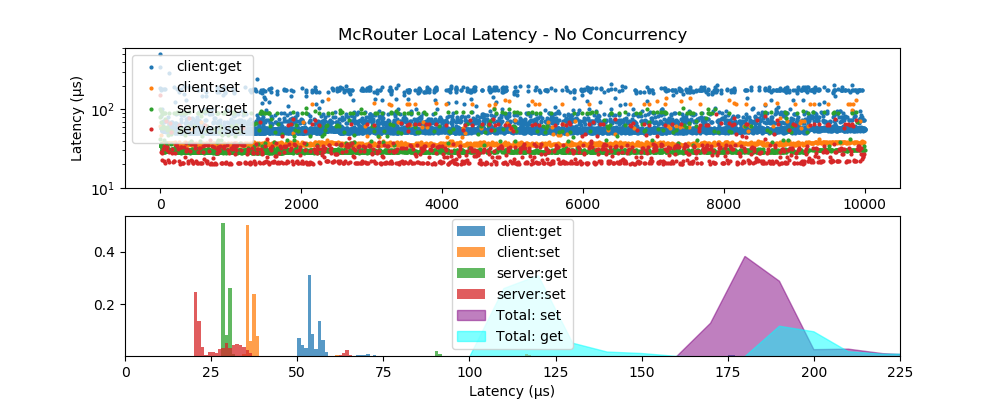

Text(0.5, 0, 'Latency (µs)')

In [794]:
%matplotlib notebook
plt.figure(figsize=(10,4))
def plot_action(df, action, label):
    plt.plot((df[df.action == action]['out'] - df[df.action == action]['in'])*1e6, '.', markersize=4,
            label = '%s:%s' % (label, action))

def plot_hist(df, action, label):
    if do_log:
        bins = np.logspace(1, np.log(250), 250)
    else:
        bins = np.arange(250)
    plt.hist((df[df.action == action]['out'] - df[df.action == action]['in'])*1e6, bins=bins,
            alpha=.75, label = "%s:%s" % (label, action), density=True)
    
def plot_memtier(d):
    diffs = np.diff(d['SET'][:,1])
    diffs = np.append([0], diffs)
    x = d['SET'][1:,0]
    x = np.append([x[0] - (x[1] - x[0])], x)
    plt.fill(x * 1e3, diffs / 100., color='purple', label='Total: set', alpha=.5)
    
    diffs = np.diff(d['GET'][:,1])
    diffs = np.append([0], diffs)
    
    x = d['GET'][1:,0]
    x = np.append([x[0] - (x[1] - x[0])], x)
    plt.fill(x * 1e3, diffs / 100., color='cyan', label='Total: get', alpha=.5)
    
plt.subplot(211)
plot_action(indf, 'get', 'client')
plot_action(indf, 'set', 'client')
plot_action(outdf, 'get', 'server')
plot_action(outdf, 'set', 'server')
plt.yscale('log')
plt.ylim([10, None])
plt.legend()
plt.ylabel("Latency (µs)")

plt.title("McRouter Local Latency - No Concurrency")

plt.subplot(212)
do_log = False
plot_hist(indf, 'get', 'client')
plot_hist(indf, 'set', 'client')
plot_hist(outdf, 'get', 'server')
plot_hist(outdf, 'set', 'server')
# plt.yscale('log')
# plt.xscale('log')
plt.ylim([.005, None])

plot_memtier(d)
plt.xlim([0, 225])
plt.legend()
plt.xlabel("Latency (µs)")


# plt.subplot(313)
# do_log=True
# plot_hist(indf, 'get', 'client')
# plot_hist(indf, 'set', 'client')
# plot_hist(outdf, 'get', 'server')
# plot_hist(outdf, 'set', 'server')
# # plt.yscale('log')
# plt.xscale('log')
# plt.ylim([.005, None])
# plt.legend()
# plot_memtier(d)
# plt.xlim([0, 300])

# plt.xlabel("Latency (µs)")

# # plt.plot(less_df['out'] - less_df['in'], '.')

In [796]:
(less_df['out'] - less_df['in']).median()

5.3939499998989504e-05

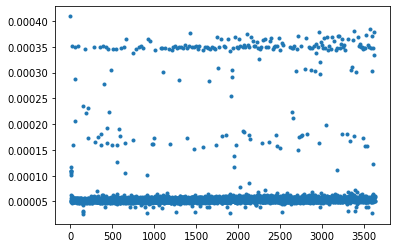

In [330]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(s_df['from'] - s_df.to, '.')

In [283]:
to_dict(c_to_mcr)

defaultdict(list,
            {"b'set:memtier-1273": [27.809876513000003],
             "b'get:memtier-1800": [27.810813909,
              27.913695163000003,
              28.104985914,
              28.164928941000003,
              28.637690816000003,
              28.746714455000003,
              28.917794597,
              29.257006901,
              29.299655374],
             "b'get:memtier-1676": [27.811733370000002,
              28.370323941000002,
              28.423927151,
              28.483457044,
              28.607376035,
              28.692413983,
              28.840531847,
              28.895997927000003,
              28.935008085000003,
              29.041919266,
              29.045834467000002,
              29.103791972000003,
              29.372844258],
             "b'get:memtier-2139": [27.812440888,
              27.843018515,
              29.120682901000002],
             "b'get:memtier-1371": [27.813057858,
              27.891269385,
            

In [191]:
sents = sorted(timestamps['10.0.0.7']['10.0.0.101'])
rcvs = sorted(timestamps['10.0.0.101']['10.0.0.7'])
outs = sorted(timestamps['10.0.0.101']['10.0.0.4'])

TypeError: list indices must be integers or slices, not str

In [136]:
len(sents), len(rcvs), len(outs)

(1221, 716, 95955)

In [137]:
np.array(rcvs[:700]) - np.array(sents[:700])

array([8.97600000e-05, 6.54480000e-05, 4.99390000e-05, 6.33300000e-05,
       5.26860000e-05, 9.30090000e-05, 9.94420000e-05, 1.81381000e-04,
       2.32304000e-04, 2.21496000e-04, 2.75172000e-04, 2.52905000e-04,
       2.70823000e-04, 2.50601000e-04, 2.30102000e-04, 2.54559000e-04,
       2.73556000e-04, 2.81742000e-04, 3.05599000e-04, 3.16149000e-04,
       3.20659000e-04, 3.41579000e-04, 3.73315000e-04, 3.85413000e-04,
       3.84825000e-04, 4.16075000e-04, 4.60793000e-04, 4.57853000e-04,
       4.61678000e-04, 5.17610000e-04, 5.36063000e-04, 6.06059000e-04,
       5.80877000e-04, 6.26052000e-04, 6.86431000e-04, 6.63056000e-04,
       6.74688000e-04, 6.88479000e-04, 7.09547000e-04, 7.22646000e-04,
       7.44452000e-04, 7.67303000e-04, 7.98057000e-04, 8.53250000e-04,
       8.80176000e-04, 9.00025000e-04, 9.33954000e-04, 9.53042000e-04,
       9.72037000e-04, 9.87802000e-04, 1.59018900e-03, 1.61165000e-03,
       1.63187100e-03, 1.65932200e-03, 1.67543800e-03, 1.67783600e-03,
      

In [131]:
len(outs)

10001